# Preprocessing of CM2.6 input for air-sea flux calculation

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, filter_inputs_dataset, weighted_coarsen, open_zarr
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params

In [3]:
fs = gcsfs.GCSFileSystem()
# load global parameters
params = get_params('v0.7.0', test=False)

temp_mapper = fs.get_mapper(params['paths']['CM26']['scratch'])
output_mapper_filter = fs.get_mapper(params['paths']['CM26']['filter'])
output_mapper_coarse = fs.get_mapper(params['paths']['CM26']['coarse'])

print(temp_mapper.root)
print(output_mapper_filter.root)
print(output_mapper_coarse.root)

leap-scratch/jbusecke/scale-aware-air-sea/temp/CM26_v0.7.0.zarr
leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CM26_filter_v0.7.0.zarr
leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CM26_coarse_50_v0.7.0.zarr


In [14]:
# fs.rm(temp_mapper.root, recursive=True)
# fs.rm(output_mapper_filter.root, recursive=True)

## Set up a legit dask cluster

In [6]:
import dask
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 32
options.worker_cores = 4

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.scale(150)
client

[ClusterReport<name=prod.7f3f70b66af7497795f363d894cec959, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.6bab2effd39249d385ab6a38cad77257/status,


In [12]:
cluster.scale(200)

## Write out the source data in a temp folder and reload

In [7]:
if not fs.exists(temp_mapper.root):
    print('Recreating temp store from scratch')
    ds_merged_raw  = load_and_combine_cm26(fs, inline_array=True)

    # Only process a small dataset if the version is a test
    if 'test' in params['version']:
        ds_merged_raw = ds_merged_raw.isel(time=slice(0,300))
    
    ds_merged_raw.to_zarr(temp_mapper) # this streams just fine 🎉
    
# overwrite with reloaded store
ds_merged = open_zarr(temp_mapper)
ds_merged

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Coarsen input fields

In [8]:
ds_coarse = weighted_coarsen(
    ds_merged, 
    {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
    'area_t'
)
ds_coarse

<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dyt           (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 370.3
    geolat_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolon_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht            (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt           (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet           (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean      (xt_ocean) float64 -277.5 -272.5 -267.5 ... 67.5 72.5 77.5
  * yt_ocean      (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    dxt           (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

### Sanity checks for the coarsened data

#### Fine and coarse datasets should preserve the global mean tracer values

Text(0.5, 1.0, 'Global weighted SST average')

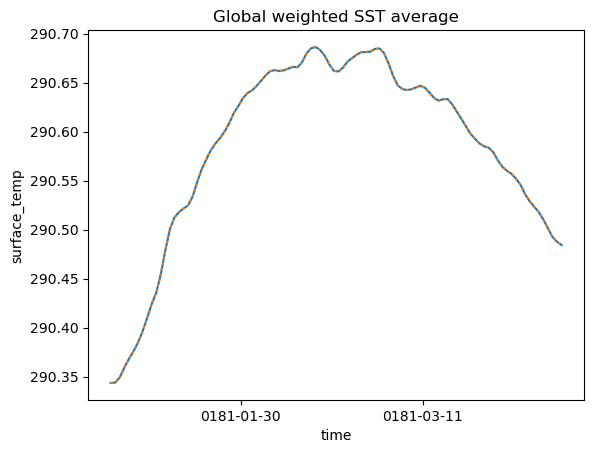

In [12]:
roi = dict(time=slice(0,100))
ds_merged_sample = ds_merged.isel(**roi)
ds_coarse_sample = ds_coarse.isel(**roi)

def w_mean_plot(ds, label, ls):
    da = ds['surface_temp']
    da.weighted(da.area_t).mean(['xt_ocean', 'yt_ocean']).plot(label=label, ls=ls)
    
w_mean_plot(ds_merged_sample, 'fine', '-')
w_mean_plot(ds_coarse_sample, 'coarse', ':')
plt.title('Global weighted SST average')

#### Are eddies visually eliminated?

This is pretty hand wavy still

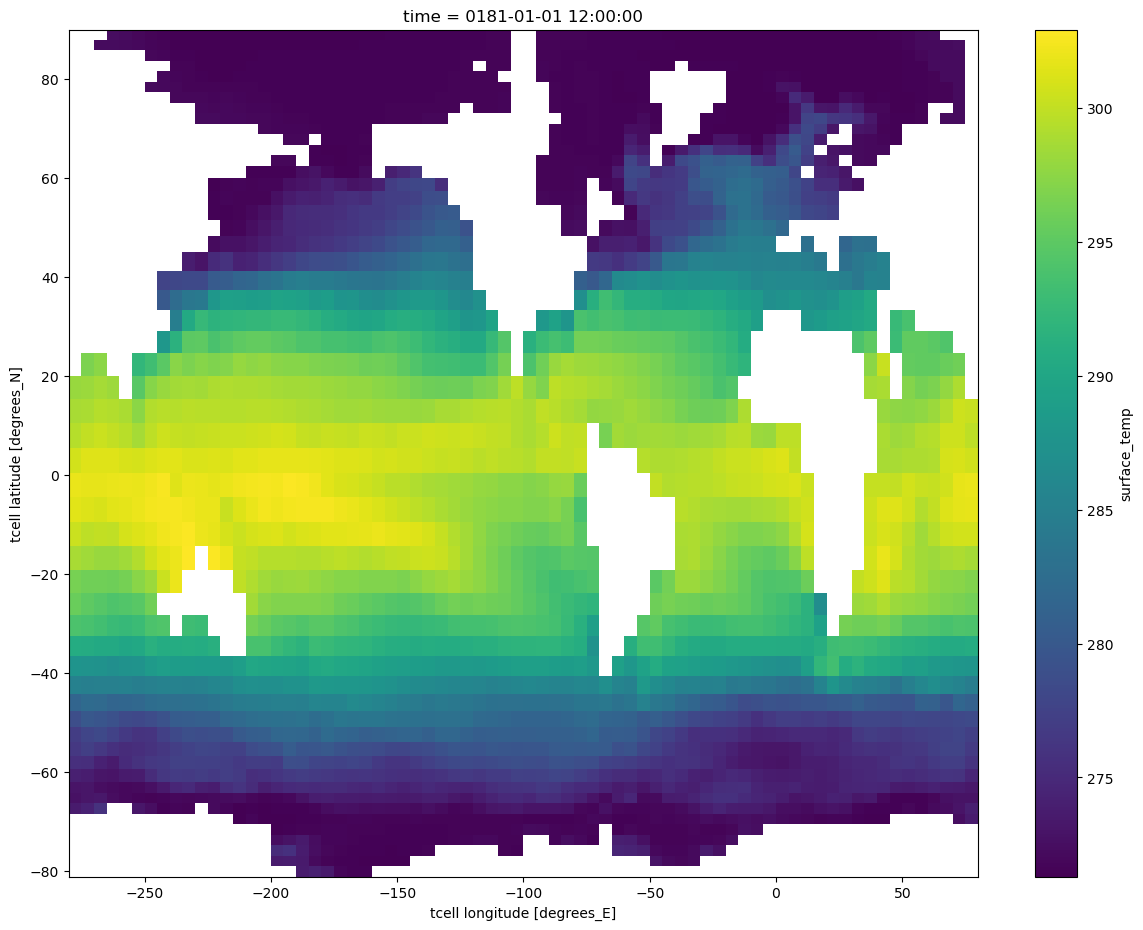

In [13]:
ds_coarse.isel(time=0).surface_temp.plot(size=11)

### Save out the Coarsened Data

In [15]:
ds_save_coarse = ds_coarse
print(f"{ds_save_coarse.nbytes/1e9} GB")
ds_save_coarse.to_zarr(output_mapper_coarse) # something is close to crapping out for this calc (scheduler?) Keep getting Service Unavailable notices.

ds_reloaded_coarse = xr.open_dataset(output_mapper_coarse, engine='zarr', chunks={}, consolidated=True)
ds_reloaded_coarse

2.499607992 GB


<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -277.5 -272.5 -267.5 ... 67.5 72.5 77.5
  * yt_ocean      (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

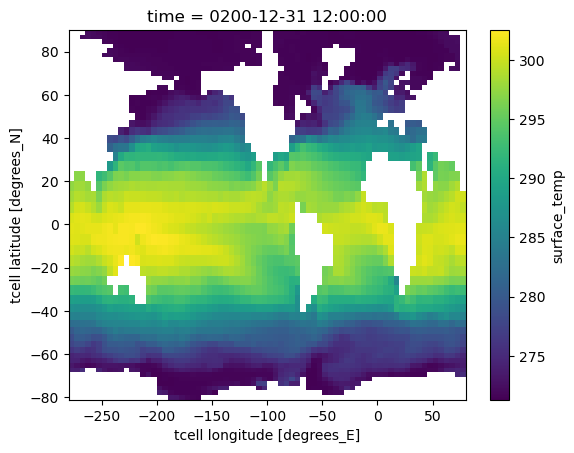

In [16]:
ds_reloaded_coarse.isel(time=-1)['surface_temp'].plot()

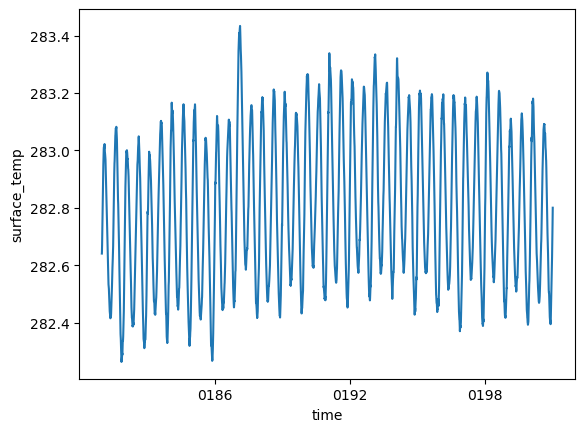

In [17]:
ds_reloaded_coarse.surface_temp.mean(['xt_ocean', 'yt_ocean']).plot()

## Filtered input fields

In [9]:
filter_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']

# filter the whole dataset with the new method
ds_merged_filtered = filter_inputs_dataset(
    ds_merged[filter_vars], 
    ['yt_ocean', 'xt_ocean'], 
    params['filter_scale'], 
    filter_type=params['filter_type'],
)

# add the filtered variables to the original dataset
for var in filter_vars:
    ds_merged[var+'_filtered'] = ds_merged_filtered[var]
    
# also rebuild a second relative wind from only ocean filtered velocities
ds_merged['u_relative_filtered_ocean_only'] = ds_merged['u_ref'] - ds_merged['u_ocean_filtered']
ds_merged['v_relative_filtered_ocean_only'] = ds_merged['v_ref'] - ds_merged['v_ocean_filtered']

ds_merged['u_relative_filtered_atmos_only'] = ds_merged['u_ref_filtered'] - ds_merged['u_ocean']
ds_merged['v_relative_filtered_atmos_only'] = ds_merged['v_ref_filtered'] - ds_merged['v_ocean']

ds_merged

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 0.0 0.0 ... 0.0
    dxt                             (yt_ocean, xt_ocean) float64 1.719e+03 .....
    dyt                             (yt_ocean, xt_ocean) float64 4.697e+03 .....
    geolat_t                        (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
    geolon_t                        (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
    ht                              (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
    kmt                             (yt_ocean, xt_ocean) float32 0.0 0.0 ... 0.0
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
    wet                             (yt_ocean, xt_ocean) float64 0.0 0.0 ... 0.0
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/25)
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean                         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Some sanity checks with the data before large batch save

#### Check that the nanmask is uniform across variables
See https://github.com/ocean-transport/scale-aware-air-sea/issues/46



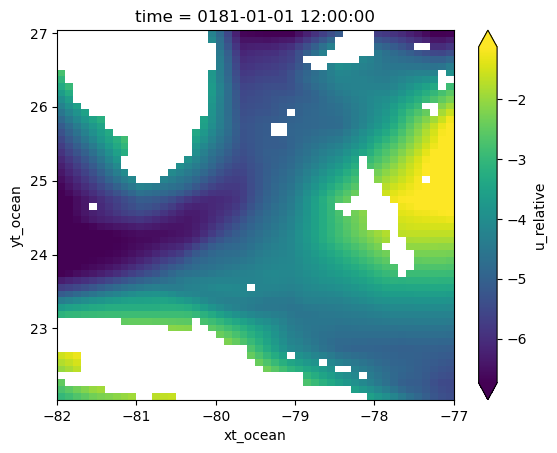

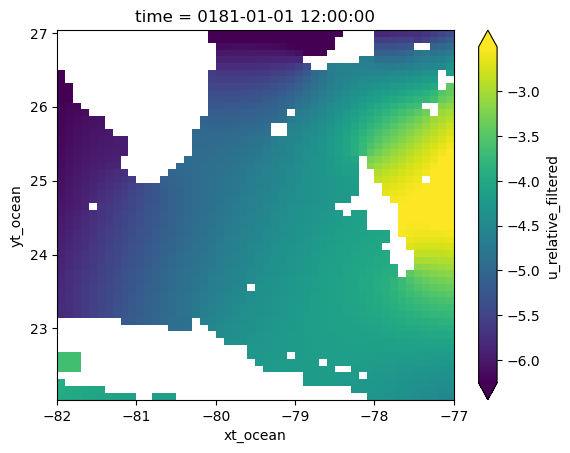

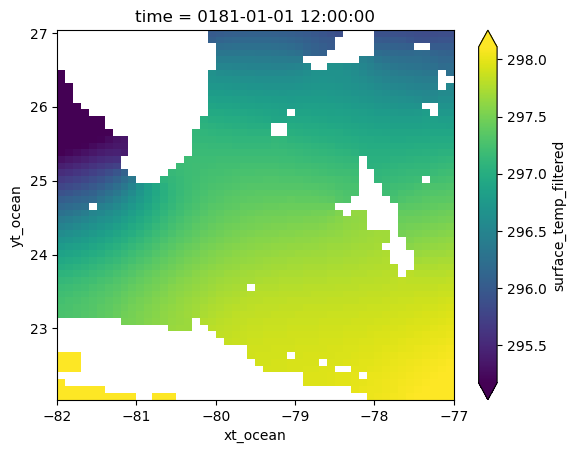

In [20]:
roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))

plt.figure()
ds_merged['u_relative'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

plt.figure()
ds_merged['u_relative_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

plt.figure()
ds_merged['surface_temp_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

In [10]:
# prune dataset for saving
keep_vars = [
    'slp_filtered', 'surface_temp_filtered',
    'u_relative_filtered','v_relative_filtered',
    'u_relative_filtered_ocean_only','v_relative_filtered_ocean_only',
    'u_relative_filtered_atmos_only','v_relative_filtered_atmos_only',
    't_ref_filtered', 'q_ref_filtered'
]
ds_save_smooth = ds_merged[keep_vars]
print(f"{ds_save_smooth.nbytes/1e12} TB")

2.84065066884 TB


### Save out the Filtered Data

In [15]:
# fs.rm(output_mapper_smooth.root, recursive=True)

to_zarr_split(ds_save_smooth, output_mapper_filter, split_interval=200) # i used to use 1000 here, but that leads to killed workers
ds_reloaded_filter = open_zarr(output_mapper_filter)
ds_reloaded_filter
# # FIXME: This is weird. I thought this worked before? It seems this is related to the number of workers... 
# What I do not understand is why the workers are killed? Because they take too long? the memory looks fine, and cpu useage is high
# as expected
# Suspicion: The filter funcs need to all be done in one go? NO, still loosing workers. WTF?
# It kills and then revives some workers untils literally everything BUT the filter func (and the map-store) tasks
# is loaded in memory, which naturally limits the amount of tasks one can chew at once.
# But choosing a small interval is terrible because the last ~3 minute interval usually only a few tasks on a single worker
# And if I remember correctly somehow after they are done, each split interval takes forever to finish
# This is weird
# KilledWorker: Attempted to run task ('open_dataset-90f23e2893ee12db5b4558bcc1da0c49surface_temp-23507b588eca1cca43a4975502cc1fa0', 3, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tls://10.0.30.3:43383. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

# 02/22/2023
# I ran into the killed worker issue again, but this seems to work with smaller batches. It seems important to have all filter tasks finish in 'one batch', meaning not having more filtering tasks than cores...
# I might be able to reproduce this with few workers and recreating the situation where multiple filtering tasks run on the same core.
# with the current config (4 cores, 32GB) I can set the split interval = num of workers

Writing to leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CM26_filter_v0.7.0.zarr ...


  0%|          | 0/36 [00:00<?, ?it/s]

2023-02-22 23:52:07,045 - distributed.client - WARNING - Couldn't gather 4 keys, rescheduling {"('store-map-ccbafb181b1048469e5254d581ab5945', 15, 0, 0)": (), "('store-map-4c3809096fbbdc840321d58703f5c05c', 12, 0, 0)": (), "('store-map-e3b2257fd515ecca9a616942ce4b63f5', 58, 0, 0)": (), "('store-map-e3b2257fd515ecca9a616942ce4b63f5', 30, 0, 0)": ()}
2023-02-22 23:59:38,997 - distributed.client - WARNING - Couldn't gather 8 keys, rescheduling {"('store-map-f982f9133524663470c70514d9a906a9', 35, 0, 0)": (), "('store-map-8f5720b073c5967e0cf1f5fb8c10b71d', 11, 0, 0)": (), "('store-map-3429c323a40951588ca7aefea14f8be8', 41, 0, 0)": (), "('store-map-24422ced0e675e7426133082fe8e24ff', 10, 0, 0)": (), "('store-map-73e150dd4d029a2c4ddadff1f1ccd58e', 65, 0, 0)": (), "('store-map-74791bd6c66fd586645ebbccb9f67696', 26, 0, 0)": (), "('store-map-d994bd812e2b6e8826112ffb4aa01930', 11, 0, 0)": (), "('store-map-e204329fdc9d1b307ecfde29cb65a1b3', 53, 0, 0)": ()}
2023-02-23 00:11:40,486 - distributed.clie

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_filtered                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_filtered           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

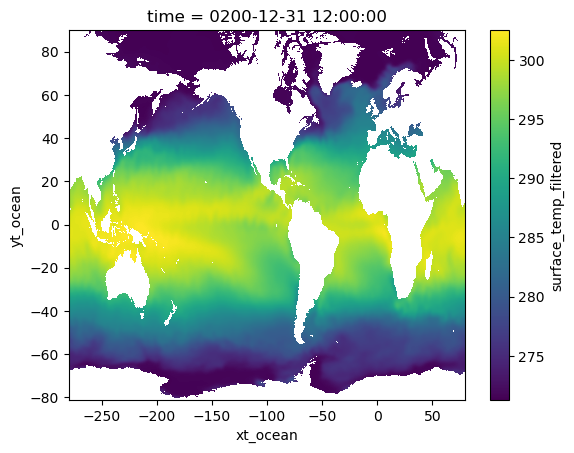

In [17]:
ds_reloaded_filter.surface_temp_filtered.isel(time=-1).plot()

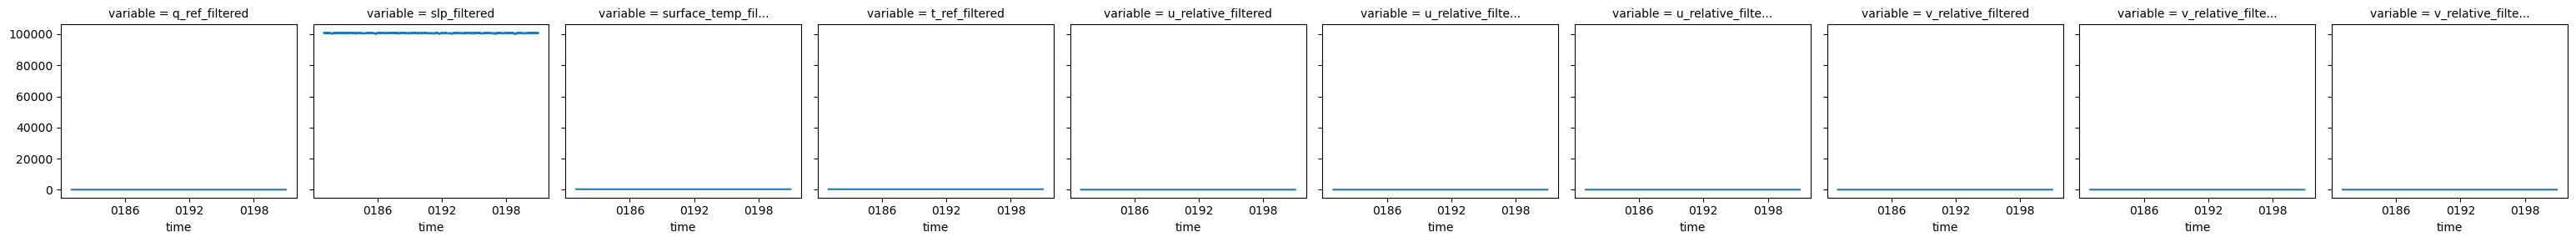

In [18]:
da_reloaded_filter = ds_reloaded_filter.to_array()
da_reloaded_filter.mean(['xt_ocean','yt_ocean']).plot(col='variable')

In [19]:
cluster.shutdown()